In [1]:
import os
import numpy as np
import h5py
from fancy import Data, Model, Analysis
from fancy.interfaces.stan import coord_to_uv

from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
'''Setting up'''
# Define location of Stan files
stan_path = '../../stan/'

# Define file containing source catalogue information
source_file = '../../data/sourcedata.h5'
uhecr_file = '../../data/UHECRdata.h5'

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# source_types = ["SBG_23", "2FHL_250Mpc", "swift_BAT_213"]
source_types = ["SBG_23"]

# detector_types = ["auger2010", "auger2014", "TA2015"]
detector_type = "TA2015"
detector_type = "auger2014"

# set random seed
random_seed = 19990308

# flag to control showing plots or not
show_plot = True

In [3]:
'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Undefined detector type!")

In [5]:
'''Fit arrival model'''

from astropy.coordinates import SkyCoord

uhecr_coord_rands = []

for source_type in source_types:
    # table file
    table_file = '../../tables/tables_{0}_{1}.h5'.format(source_type, detector_type)    
    # define output files
    arrival_output_file = 'output/arrival_fit_data_{0}_{1}.h5'.format(source_type, detector_type)

    # construct Dataset
    data = Data()
    data.add_source(source_file, source_type)
    data.add_uhecr(uhecr_file, detector_type)
    data.add_detector(detector_properties)

    # modify the right ascensions of uhecr data
    uhecr_coord = data.uhecr.coord
    uhecr_coord_icrs = uhecr_coord.icrs  # convert to icrs frame

    # right ascension and declination
    uhecr_ra = uhecr_coord_icrs.ra.deg
    uhecr_dec = uhecr_coord_icrs.dec.deg
    # randomize right ascension
    uhecr_ra_rand = (uhecr_ra + np.random.rand(len(uhecr_ra)) * 360.) % 360.

    uhecr_coord_rand = SkyCoord(ra=uhecr_ra_rand, dec=uhecr_dec, frame="icrs", unit="deg")
    data.uhecr.coord = uhecr_coord_rand.galactic
    # also set unit vector
    data.uhecr.unit_vector = coord_to_uv(data.uhecr.coord)
    
    uhecr_coord_rands.append(uhecr_coord_rand)

    # construct arrival model obejct
    arrival_model = stan_path + 'arrival_direction_model.stan'
    model = Model(model_filename = arrival_model, include_paths = stan_path)
    model.compile()
    model.input(Eth = Eth) # EeV

    # What is happening 
    # summary = b'Fit of the joint model to the Auger data' 
    summary = b'Fit of the arrival direction model to data' 
        
    # Define an Analysis object to bring together Data and Model objects
    analysis = Analysis(data, model, analysis_type = 'joint', 
                        filename = arrival_output_file, summary = summary)

    # Define location of pre-computed values used in fits 
    # (see relevant notebook for how to make these files) 
    # Each catalogue has a file of pre-computed values
    analysis.use_tables(table_file)

    # Fit the Stan model
    fit = analysis.fit_model(chains = 16, iterations = 500, seed = random_seed)

    # Save to analysis file
    analysis.save()

Using cached StanModel


Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


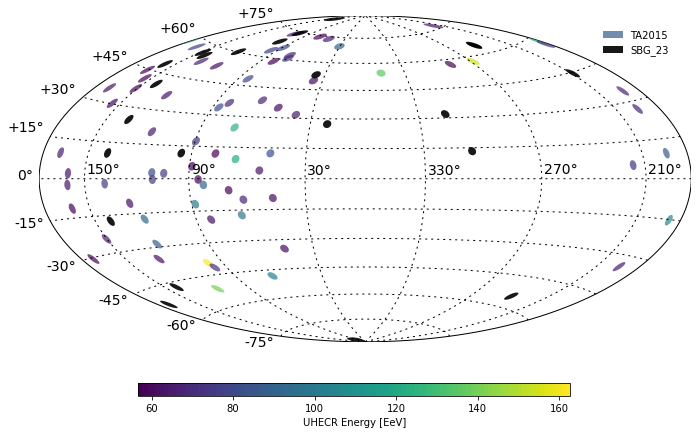

In [6]:
'''Fit joint model'''
for i, source_type in enumerate(source_types):
    # table file
    table_file = '../../tables/tables_{0}_{1}.h5'.format(source_type, detector_type)        
    # define output files
    joint_output_file = 'output/joint_fit_data_{0}_{1}.h5'.format(source_type, detector_type)

    # construct Dataset
    data = Data()
    data.add_source(source_file, source_type)
    data.add_uhecr(uhecr_file, detector_type)
    data.add_detector(detector_properties)

    # modify right ascension
    data.uhecr.coord = uhecr_coord_rands[i]
    data.uhecr.unit_vector = coord_to_uv(data.uhecr.coord)

    if show_plot:
        data.show()

    joint_model = stan_path + 'joint_model.stan'
    model = Model(model_filename = joint_model, include_paths = stan_path)
    model.compile()
    model.input(Eth = Eth) # EeV

    # What is happening 
    # summary = b'Fit of the joint model to the Auger data' 
    summary = b'Fit of the joint model to data' 
        
    # Define an Analysis object to bring together Data and Model objects
    analysis = Analysis(data, model, analysis_type = 'joint', 
                        filename = joint_output_file, summary = summary)

    # Define location of pre-computed values used in fits 
    # (see relevant notebook for how to make these files) 
    # Each catalogue has a file of pre-computed values
    analysis.use_tables(table_file)

    # Fit the Stan model
    fit = analysis.fit_model(chains = 16, iterations = 500, seed = random_seed)

    # Save to analysis file
    analysis.save()